In [1]:
import random
import numpy as np

def GenerateRealHPI():
    # create a basic time series
    start = random.uniform(15, 18)
    stop = random.uniform(117, 120)
    step = random.uniform(0.25, 0.35)
    times = np.arange(start, stop, step, dtype = float)
    # occasionally add a gap (e.g. camera malfunction)
    gap = 0
    for i in range(len(times)):
        g = random.random() * len(times) # once every few videos
        if g < 1:
            g = random.uniform(0, 2) # the gap is between 0 and 2 hours
            #print('gap:', g)
            gap += g # accumulate gap in case it happens more than once
        times[i] += gap
    # round
    times = np.round(times, 1) # the timestamp is rounded
    return times

def SimulateOCRResult(real_times):
    ocr_times = np.array(real_times) # copy the input
    for time_index in range(len(real_times)):
        real_time_str = str(real_times[time_index])
        ocr_time_str = ''
        for char_index in range(len(real_time_str)):
            # occasionally replace a digit with a random one
            # a more accurate simulation would be to have higher probabilities for similar digits, e.g. 1-7, 8-3, etc.
            if real_time_str[char_index] != '.' and random.random() * 20 < 1:
                new_digit = random.randrange(11)
                if new_digit < 10: # a digit of 10 represents erasing the digit altogether
                    ocr_time_str += str(new_digit)
                elif char_index == len(real_time_str) - 1:
                    # if it was the last digit being erased then we need to move the decimal dot
                    ocr_time_str = ocr_time_str[:-2] + '.' + ocr_time_str[-2]
            else:
                ocr_time_str += real_time_str[char_index]
        ocr_times[time_index] = round(float(ocr_time_str), 1)
    return ocr_times

In [2]:
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns; sns.set()
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# this method visualizes 2D points with a different color for each class.
def visClustering(data, labels, outliers=True):
    palette = sns.color_palette("hls", len(set(labels)))   
    uniqueLabels = list(set(labels))
    random.shuffle(uniqueLabels)
    colorMap = {l : [c] for l, c in zip(uniqueLabels, palette)} # map labels to colors
    colorMap[-1] = [(0.5,0.5,0.5)] # gray color for outliers
    for (x, y, t) in zip(data[:,0], data[:,1], labels):
        if outliers == True or t != -1:
            plt.scatter(x, y, c=colorMap[t], s=0.5,alpha=0.3)           
            
# This method corrects an increasing time series with gaps (detects outliers and
# fits a collection of consecutive lines with intermediate interpolations if necessary).
# data - the time series to correct.
# real - the correct result (optional).
# vis - enables visualization of intermediate results and the final model.
# eps1D, eps2D - determine the sensitivity to gaps and outliers, respectively (higher values = less sensitive).
# minPointsForLine - the minimum number of points required to define a line (small clusters = outliers). 
def timeRegressionWithGaps(data, real=None, vis=False, eps1D=0.8, eps2D=1.6, minPointsForLine=4):
    
    # vis real
    if vis and real is not None:
        plt.figure(dpi=1000)
        plt.plot(range(len(real)), real, linewidth=0.5, color='black')
        plt.title('Real', fontsize=10)
        plt.axis('off')
        plt.show();
       
    # find clusters and detect outliers
    data1D = data.reshape(-1,1) # just the y values
    data2D = np.array(list(zip(range(len(data)), data))) # include frame number (x values)              
    clustering1D = DBSCAN(eps=eps1D, min_samples=3).fit(data1D) # cluster y points to seperate them by gaps
    clustering2D = DBSCAN(eps=eps2D, min_samples=3).fit(data2D) # cluster (x,y) points to detect outliers
    labels = -np.ones(data.shape).astype(int) # init for labels
    
    # get the labels of the clustered y points not considered to be outliers as (x,y) points
    for i in range(len(data)):
        if clustering2D.labels_[i] != -1:
            labels[i] = clustering1D.labels_[i] 
       
    
    ####################################
    # NEW (!!!!!!!!!!!!!!!!!!!!!!!!!!) #
    ####################################           
    # mark as outliers all y points that are smaller than previous
    # y's that were not considered to be outliers as (x,y) points
    mx = -1
    for i in range(len(data)):
        if labels[i] != -1:
            if data[i] <= mx:
                labels[i] = -1
            mx = max(mx, data[i])
    ####################################


    # mark small clusters as outliers
    if minPointsForLine > 1:
        labelsWithEnoughPoints = set([l for l in np.unique(labels)  
                          if l != -1 and list(labels).count(l) > minPointsForLine])
        for i in range(len(labels)):
            if labels[i] not in labelsWithEnoughPoints:
                labels[i] = -1

    # make lists of (x,y) points from y clusters
    temp = {}
    for i in range(len(labels)):
        if labels[i] != -1:
            while True:
                try:
                    temp[labels[i]].append(data2D[i])
                    break
                except:
                    temp[labels[i]] = []
    pointLists = [np.array(temp[k]) for k in temp.keys()]

    # make a list of linear regression models fitted on the above lists
    lineRegressions = []
    for i in range(len(pointLists)):
        linReg = LinearRegression()
        linReg = linReg.fit(pointLists[i][:,0].reshape(-1,1), pointLists[i][:,1].reshape(-1,1)) 
        lineRegressions.append(linReg)

    # vis regression lines
    if vis:
        plt.figure(dpi=1000)
        for i in range(len(lineRegressions)):
            x = [[pointLists[i][0][0]], [pointLists[i][-1][0]]]
            plt.plot(x, lineRegressions[i].predict(x), color='red', linewidth=0.5)
        plt.title('Predicted Regression Lines', fontsize=10)
        plt.axis('off')
        plt.show();

    # predict f(x) for x in {0,1,2,3,...} using the above regression models
    if len(lineRegressions) == 0:
        print("Error: no regression models defined!")
        return None
    i = 0 # current model index
    pred = [] # f(x) values
    for x in range(len(data)):
        if i == len(pointLists):
            # predict the remaining f(x) values using the last model
            pred.append(lineRegressions[i-1].predict(np.array([[x]])))
            continue
        # if x is within the current line or before the first line   
        elif (x >= pointLists[i][0][0] and x <= pointLists[i][-1][0]) or x < pointLists[0][0][0]:
            pred.append(lineRegressions[i].predict(np.array([[x]])))
        # x is between lines
        else:
            # interpolate the predictions of the two models
            t = (x - pointLists[i-1][-1][0]) / (pointLists[i][0][0] - pointLists[i-1][-1][0])
            predLeft = lineRegressions[i-1].predict(np.array([[x]]))
            predRight = lineRegressions[i].predict(np.array([[x]]))
            pred.append((1 - t) * predLeft + t * predRight)
        # if x is the last point of the current line
        if x == pointLists[i][-1][0]:
            i += 1 # next model
    pred = np.squeeze(np.array(pred))
            
    # vis prediction
    if vis:
        mse = None
        realTitle = ''
        plt.figure(dpi=1000)
        visClustering(data2D, labels)
        plt.plot(range(len(data)), data, linewidth=0.7, color='red', alpha=0.5)
        plt.plot(range(len(pred)), pred, linewidth=0.5, color='yellow')
        if real is not None:
            realTitle = 'Real (black line),\n'
            mse = np.mean((pred - real) ** 2)
            plt.plot(range(len(real)), real, linewidth=0.2, color='black')
        plt.title('Data (red line),\n' + realTitle +\
                  'Predicted (yellow line),\n Regression Defining Points (colored points),\n Outliers (gray points)',
                  fontsize=10)
        plt.axis('off')
        plt.show();
        print('mse: ' + str(mse))
    
    return pred

In [3]:
real = GenerateRealHPI()
simul = SimulateOCRResult(real)

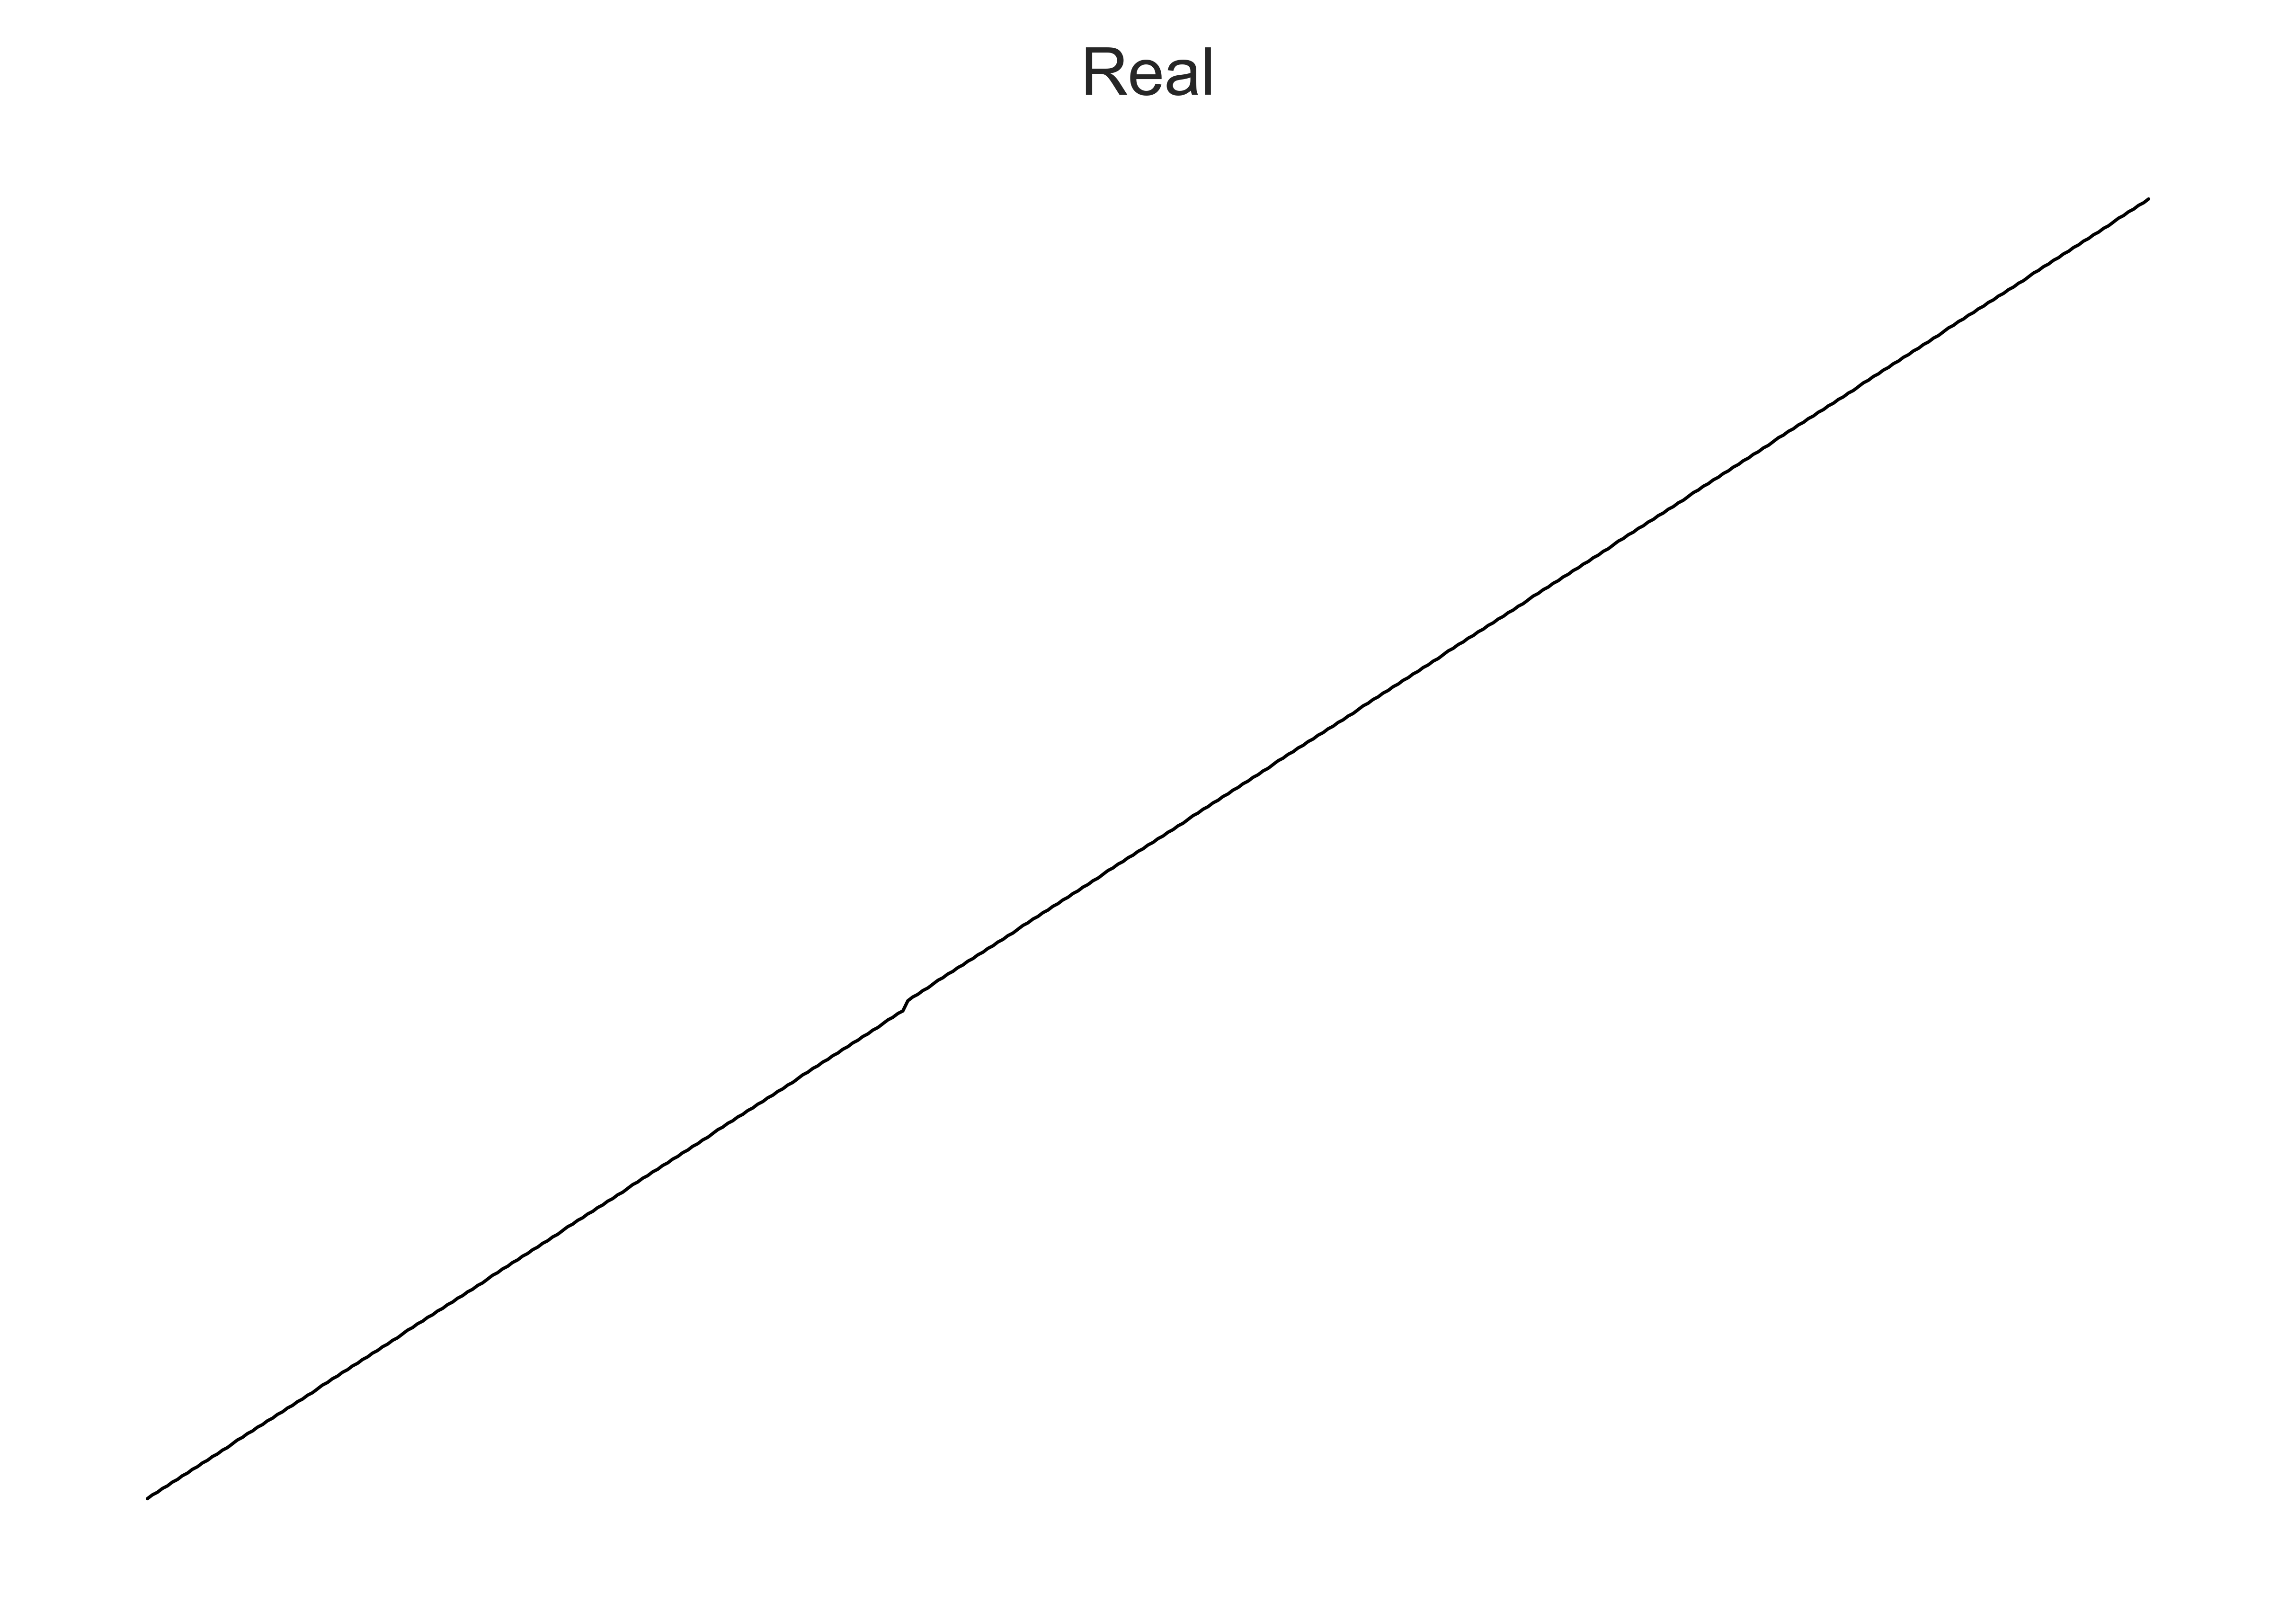

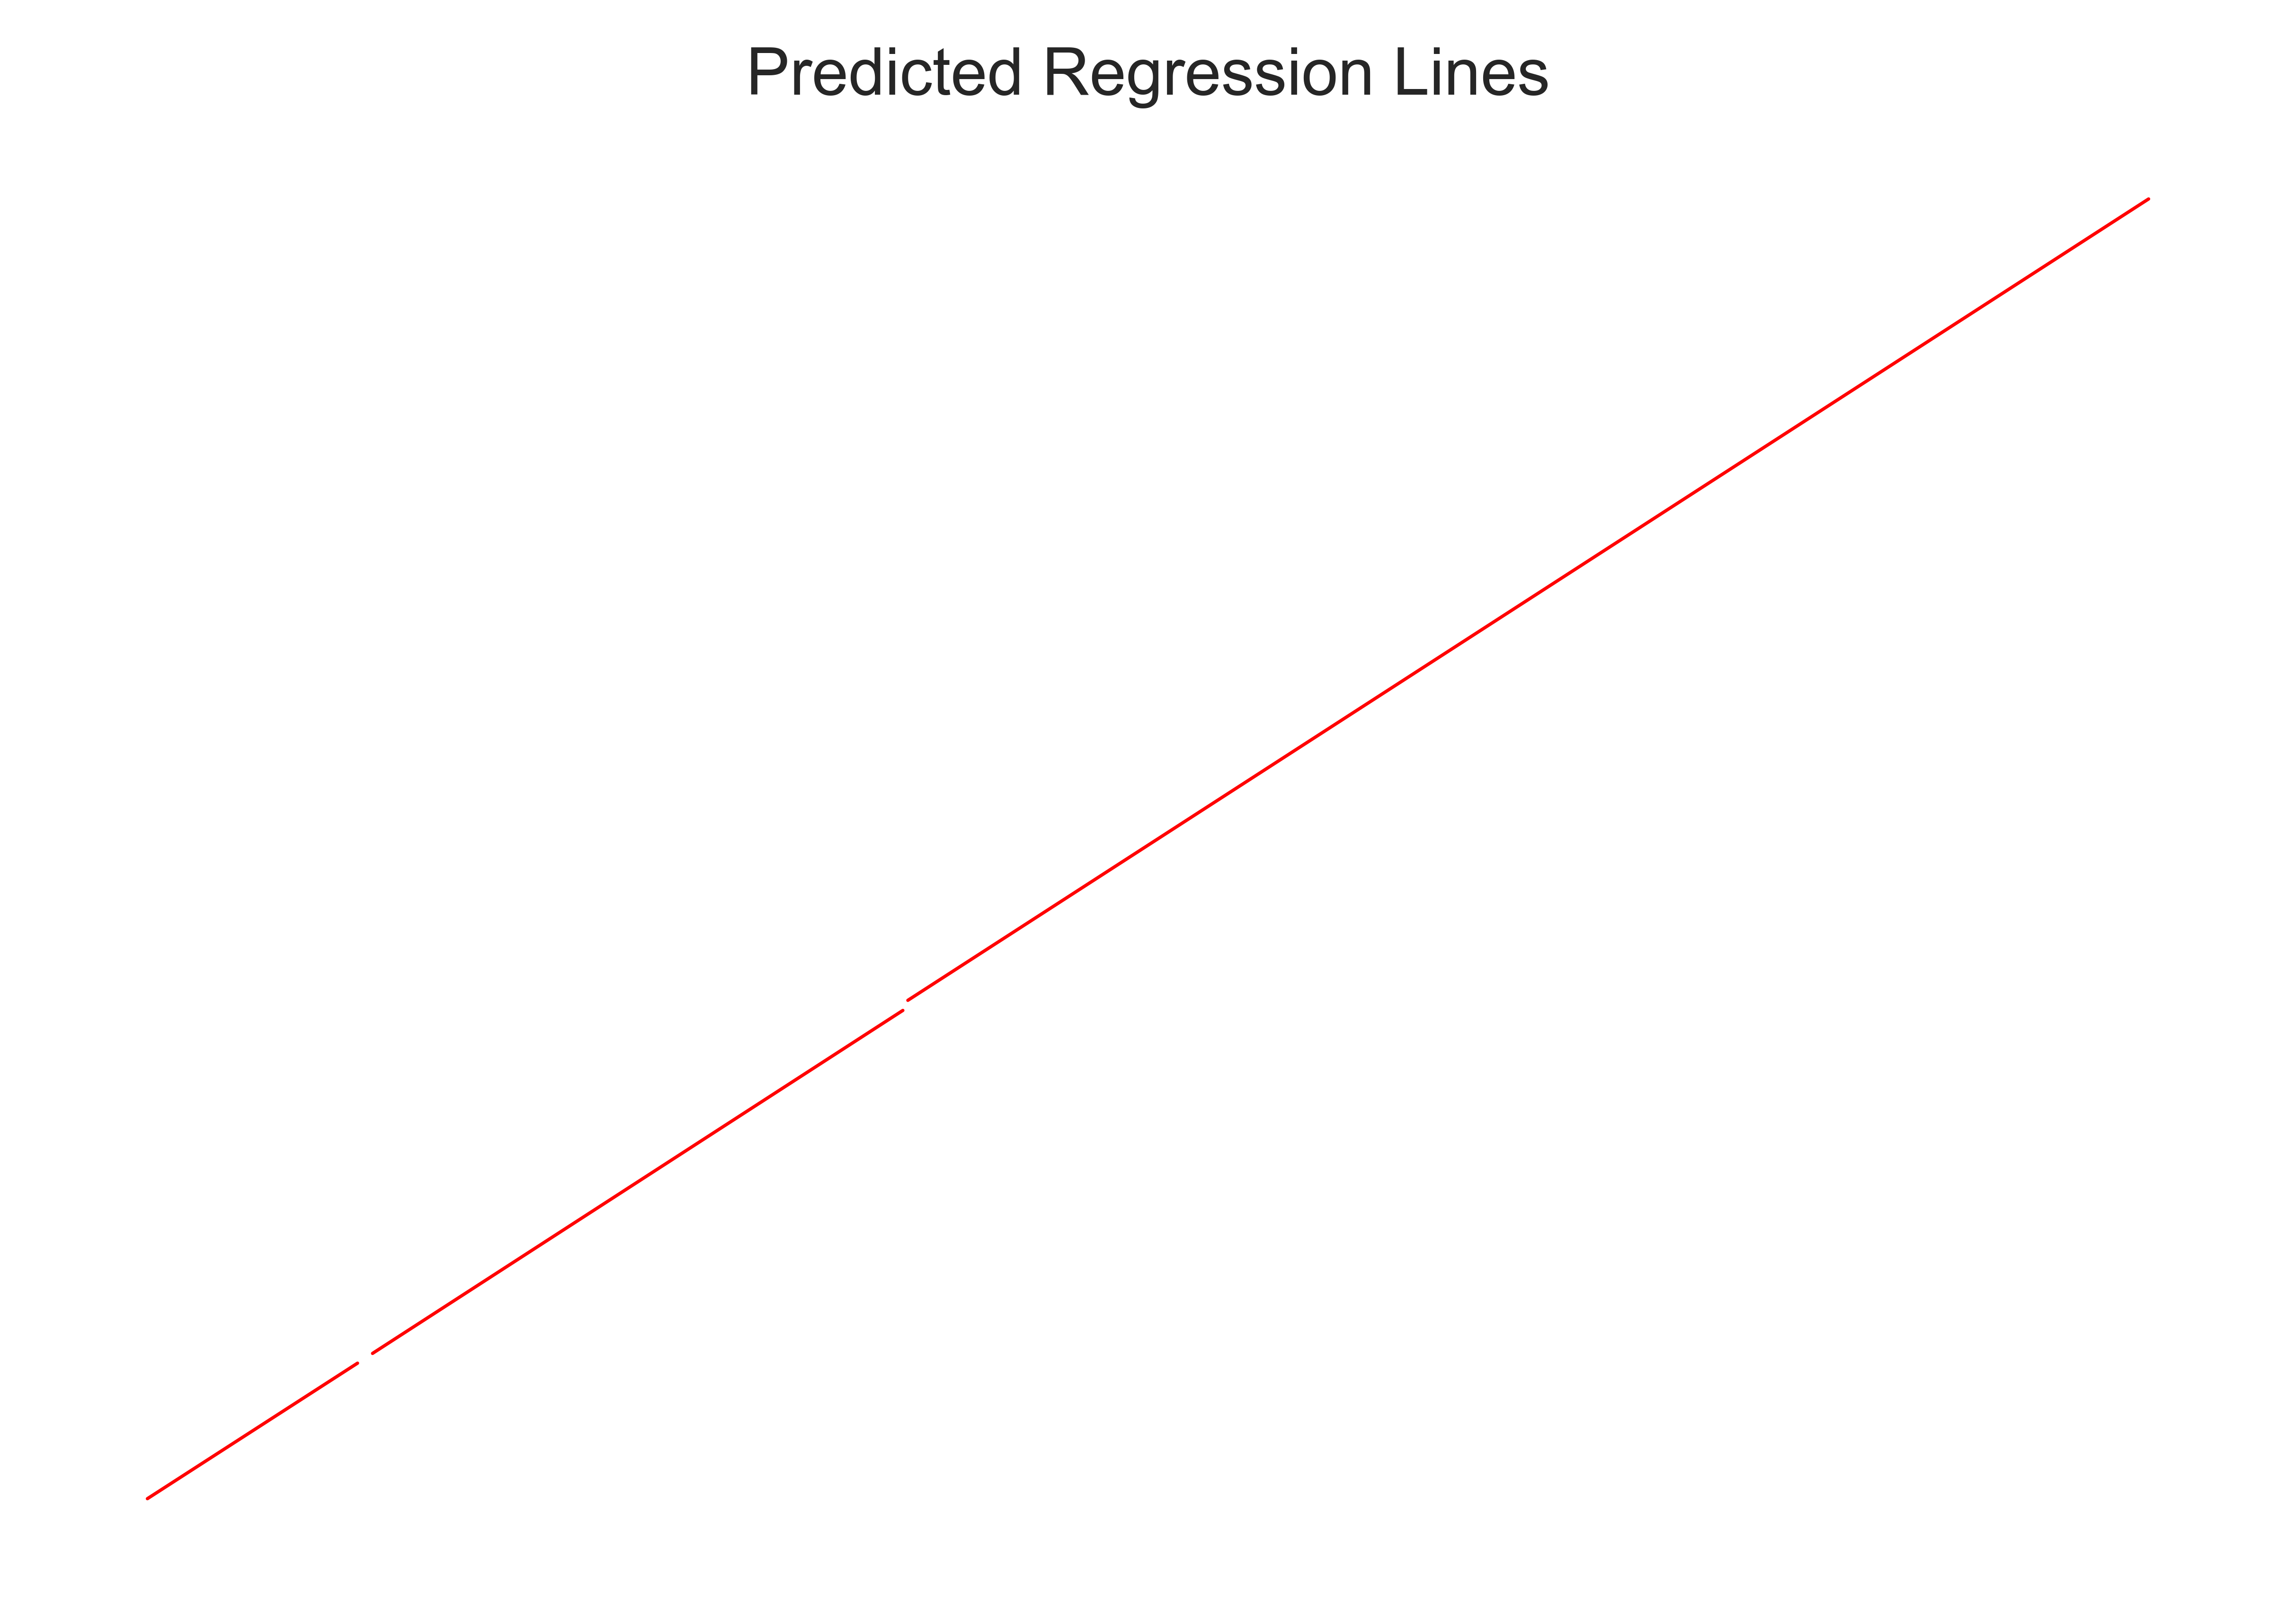

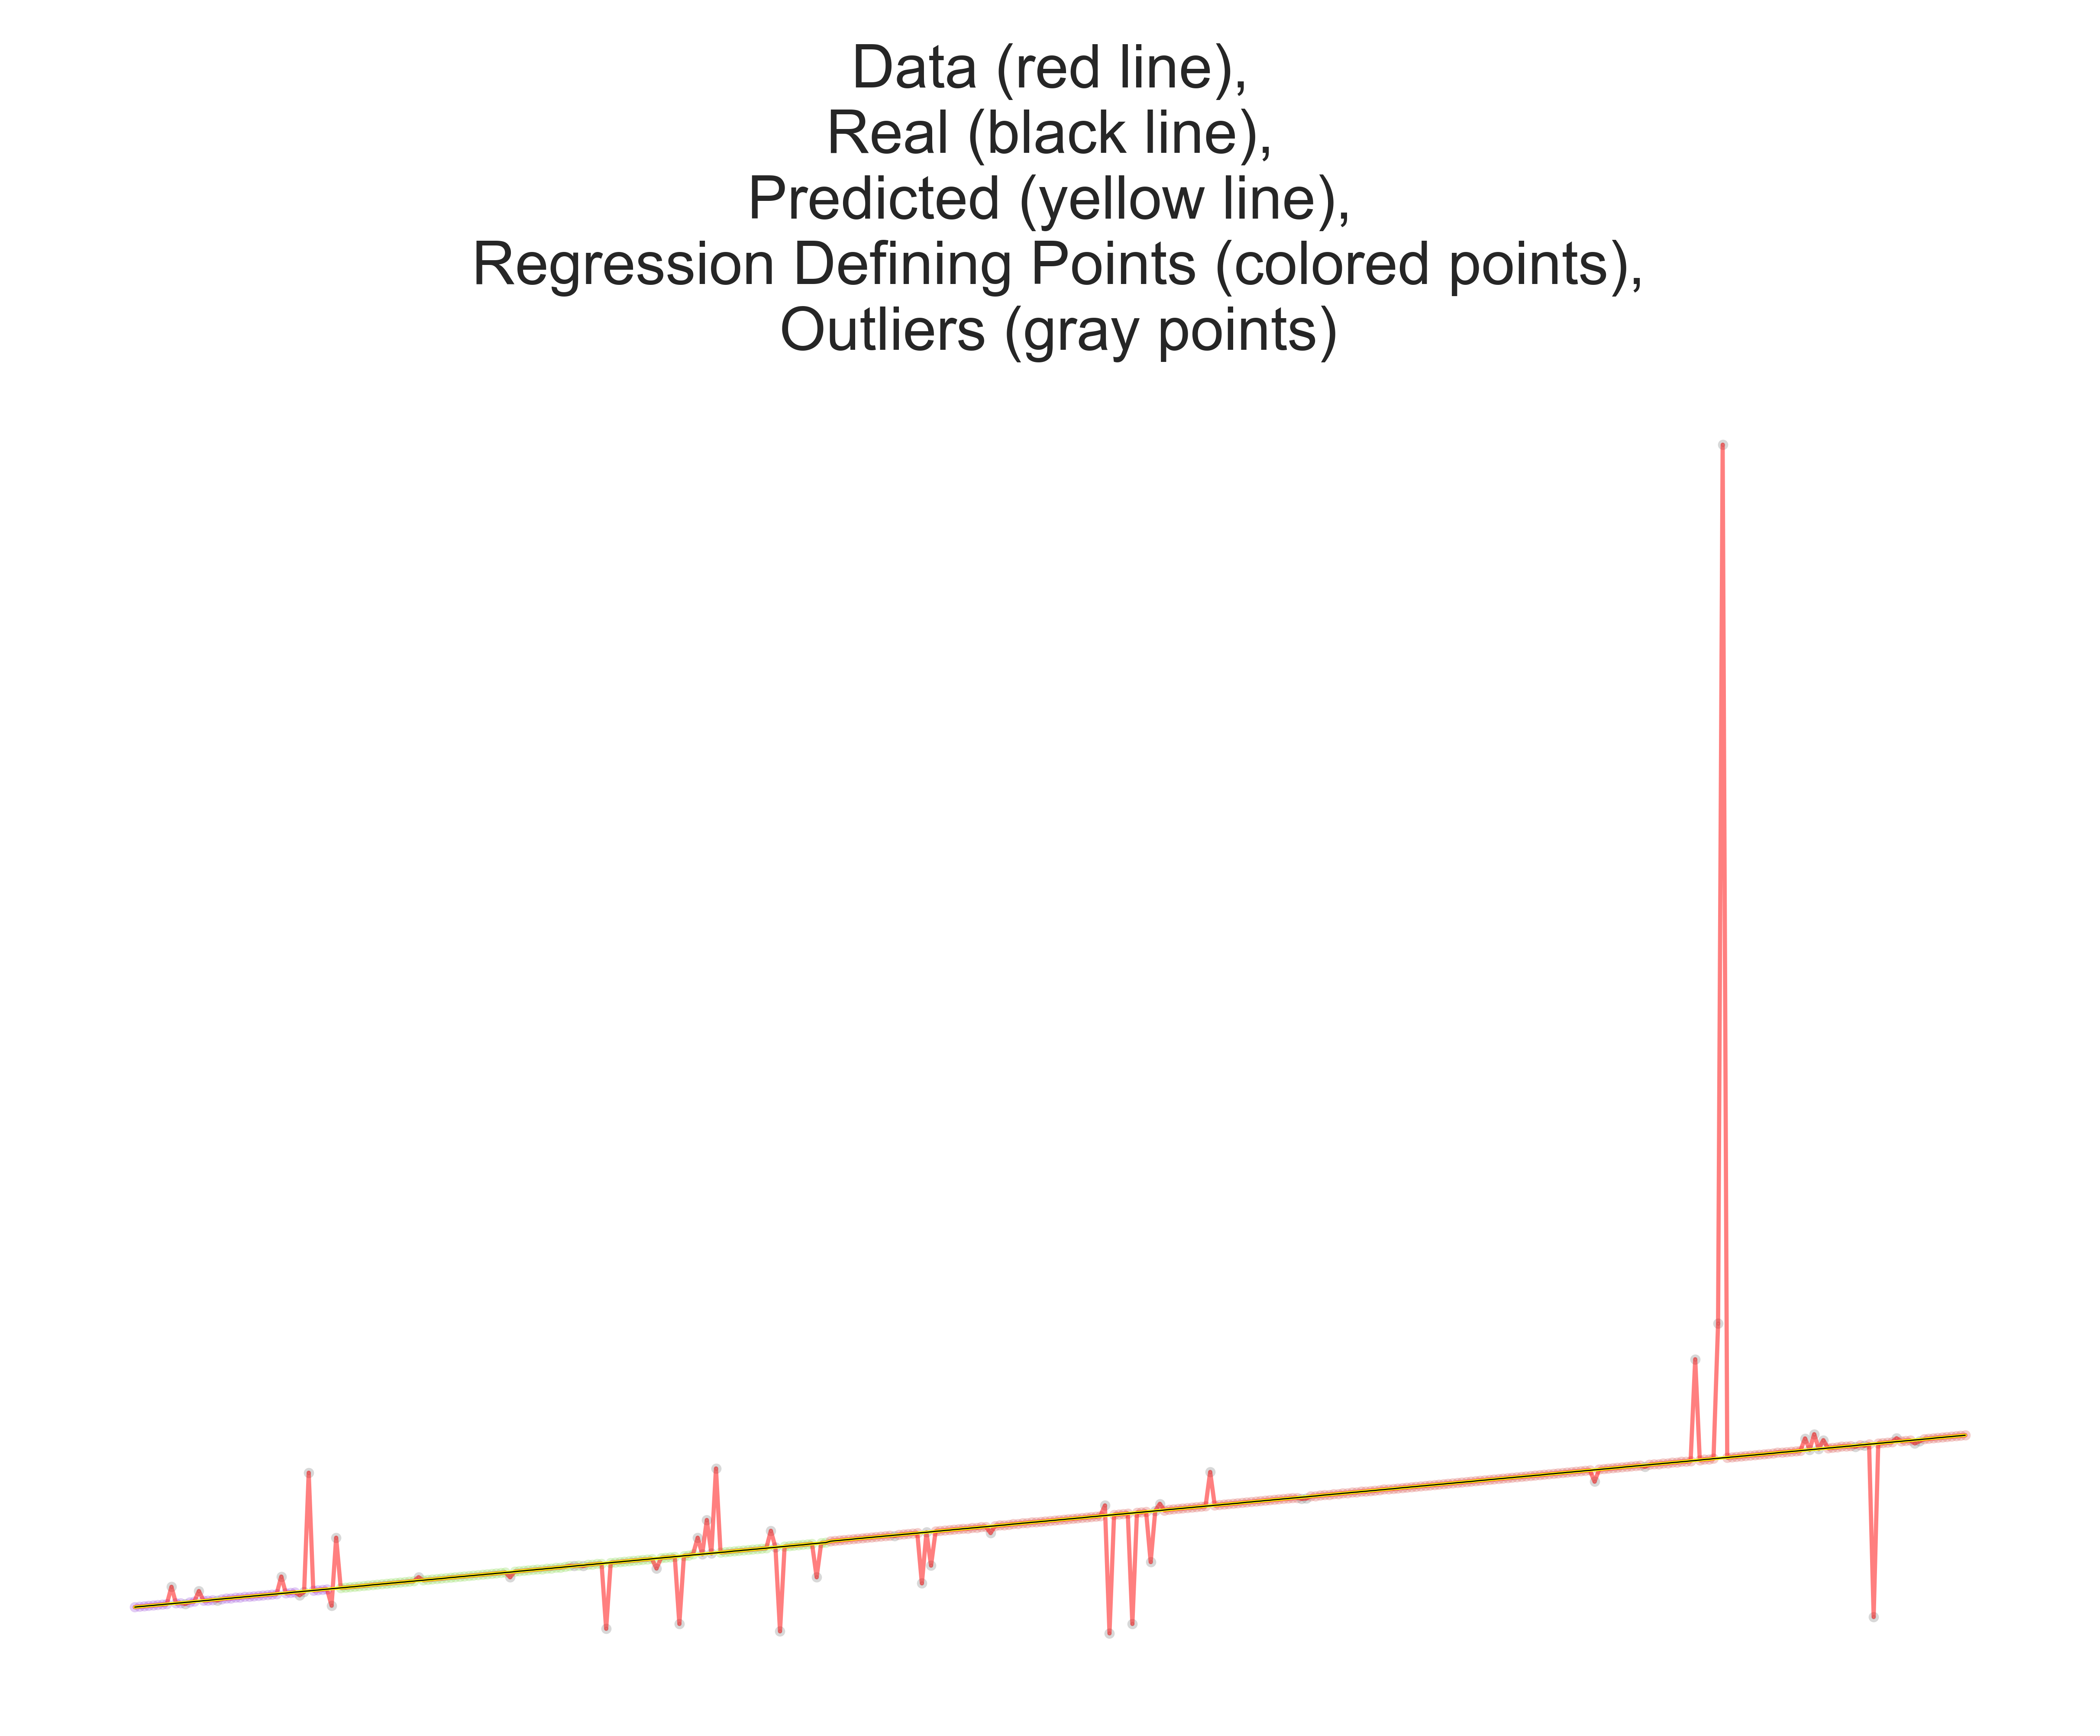

mse: 0.0008907635414605994


In [4]:
pred = timeRegressionWithGaps(data=simul, real=real, vis=True)

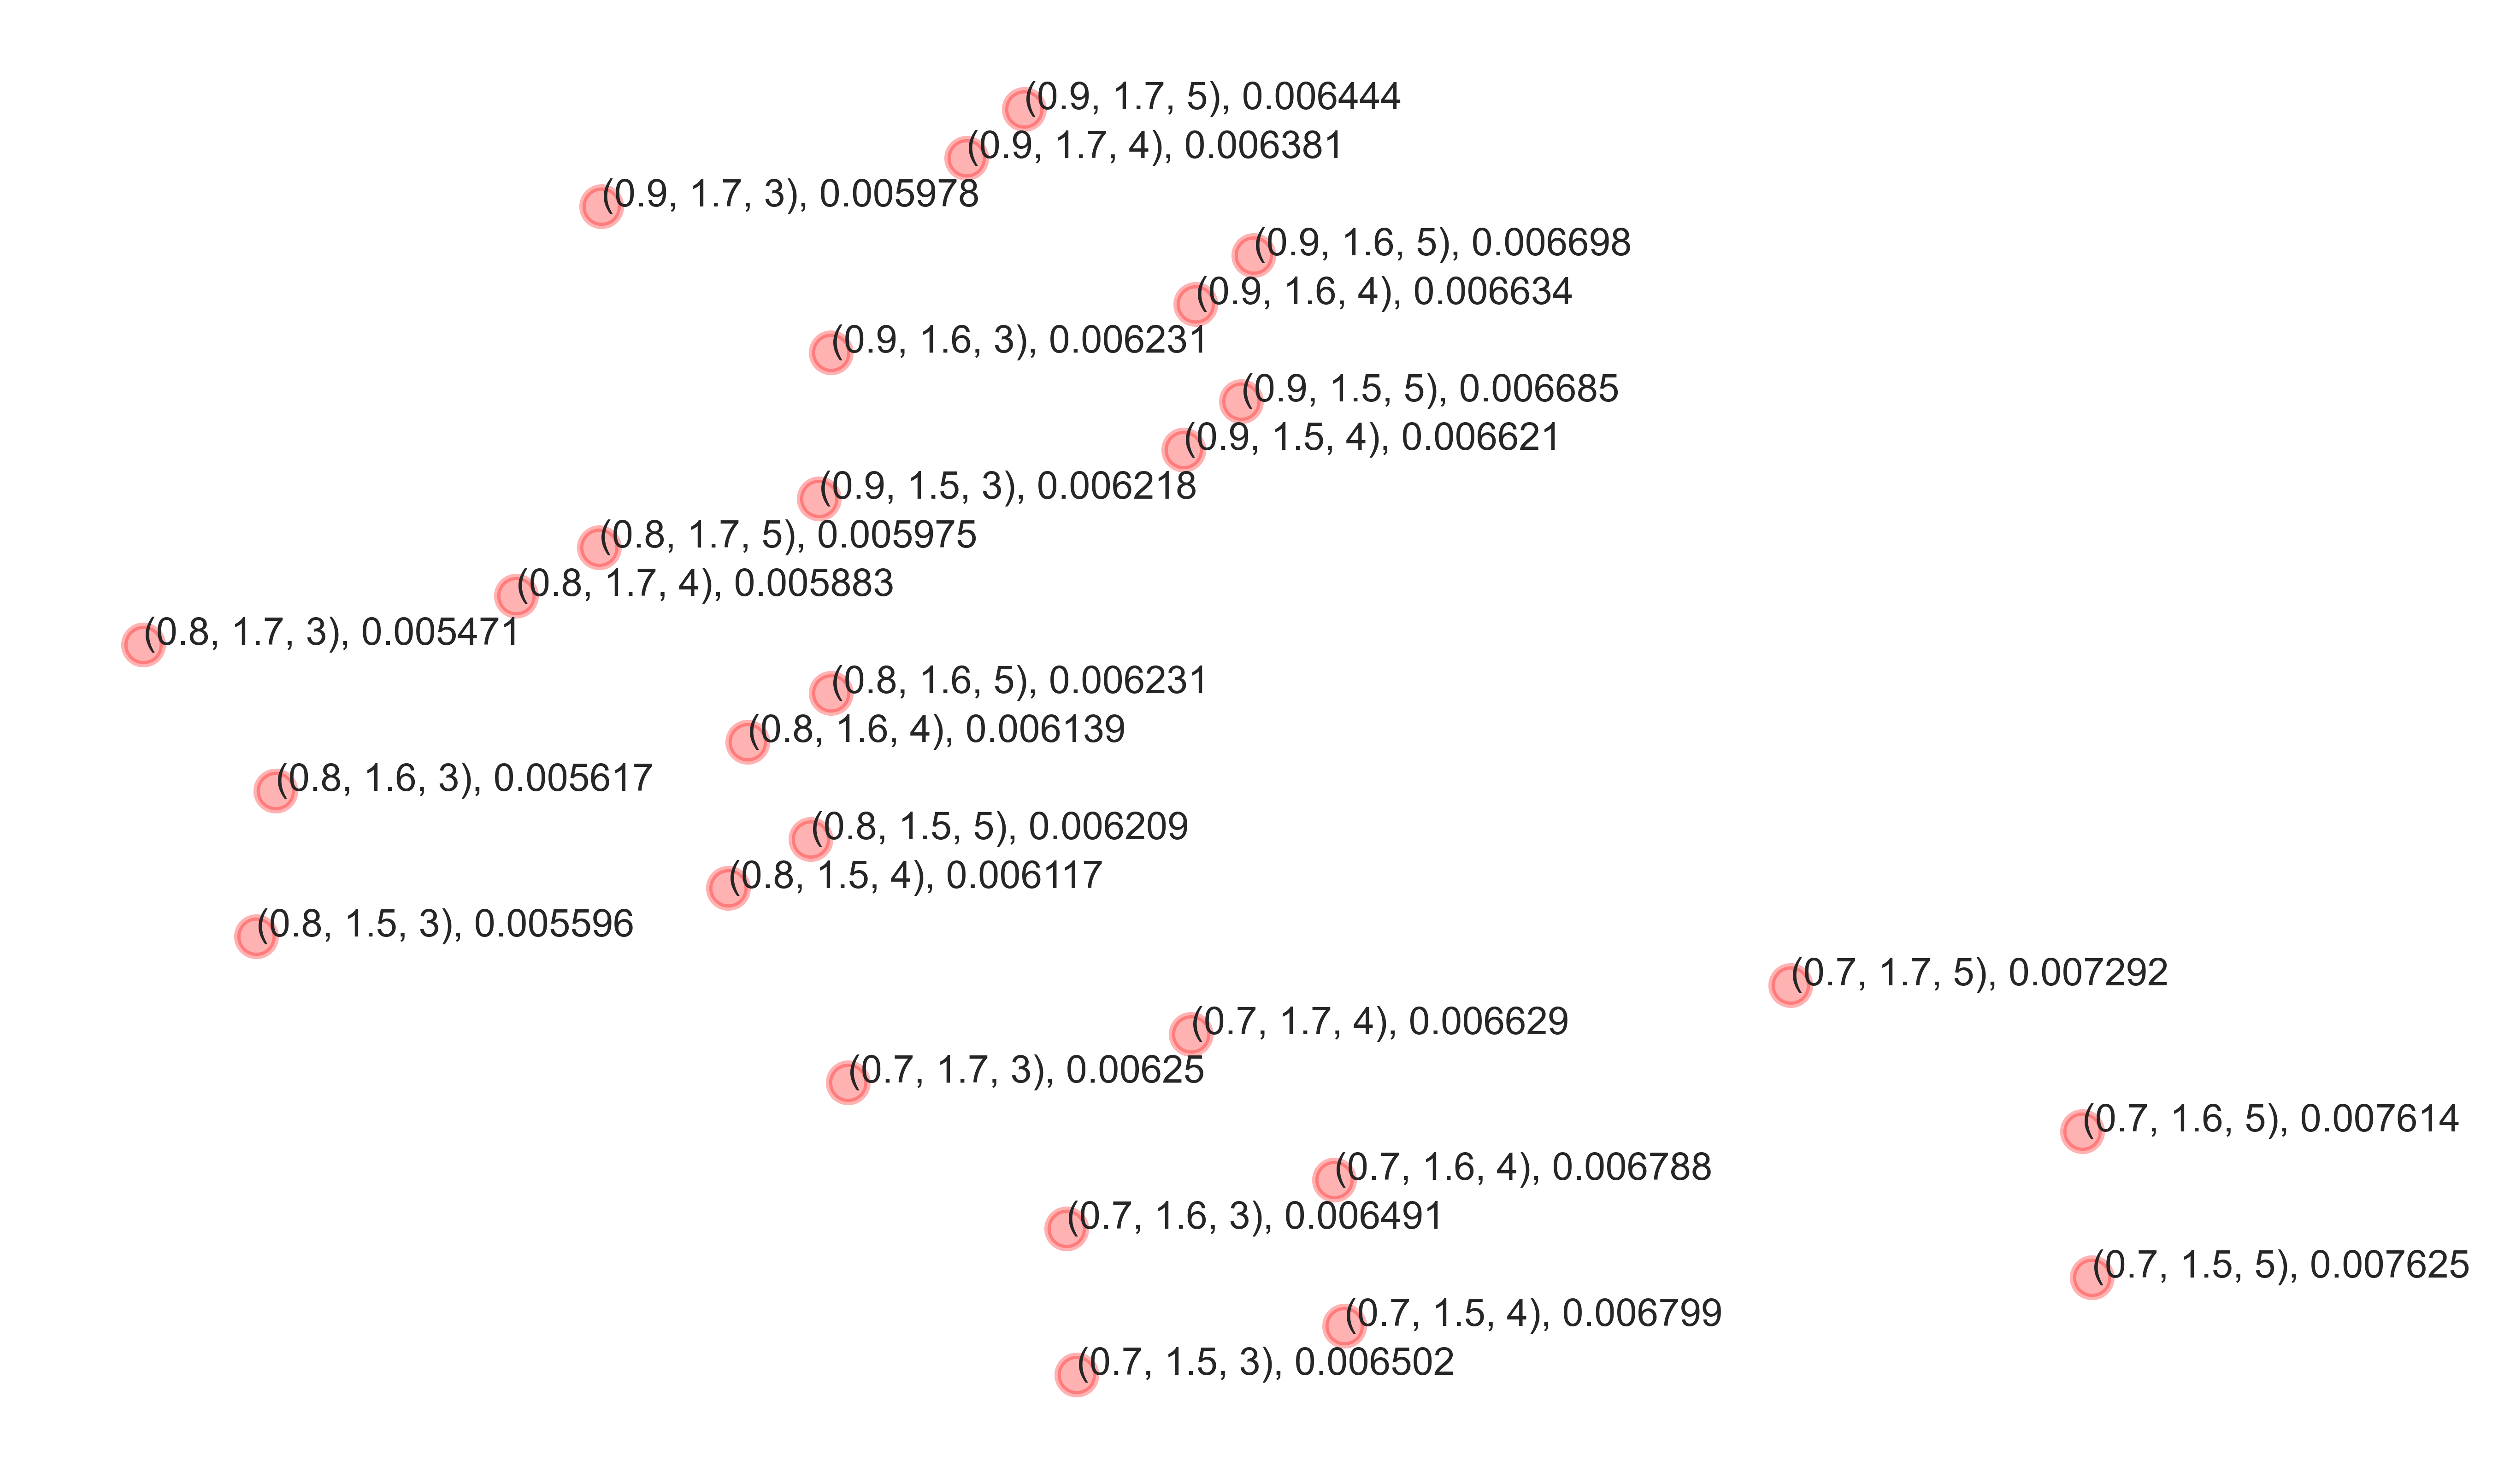

outliers:
None

best params:	(0.8, 1.7, 3)
mmse:	0.005471249856610468
msestd:	0.007726244715844531
msemax:	0.04159141542123044
msemin:	0.0008551976284755948


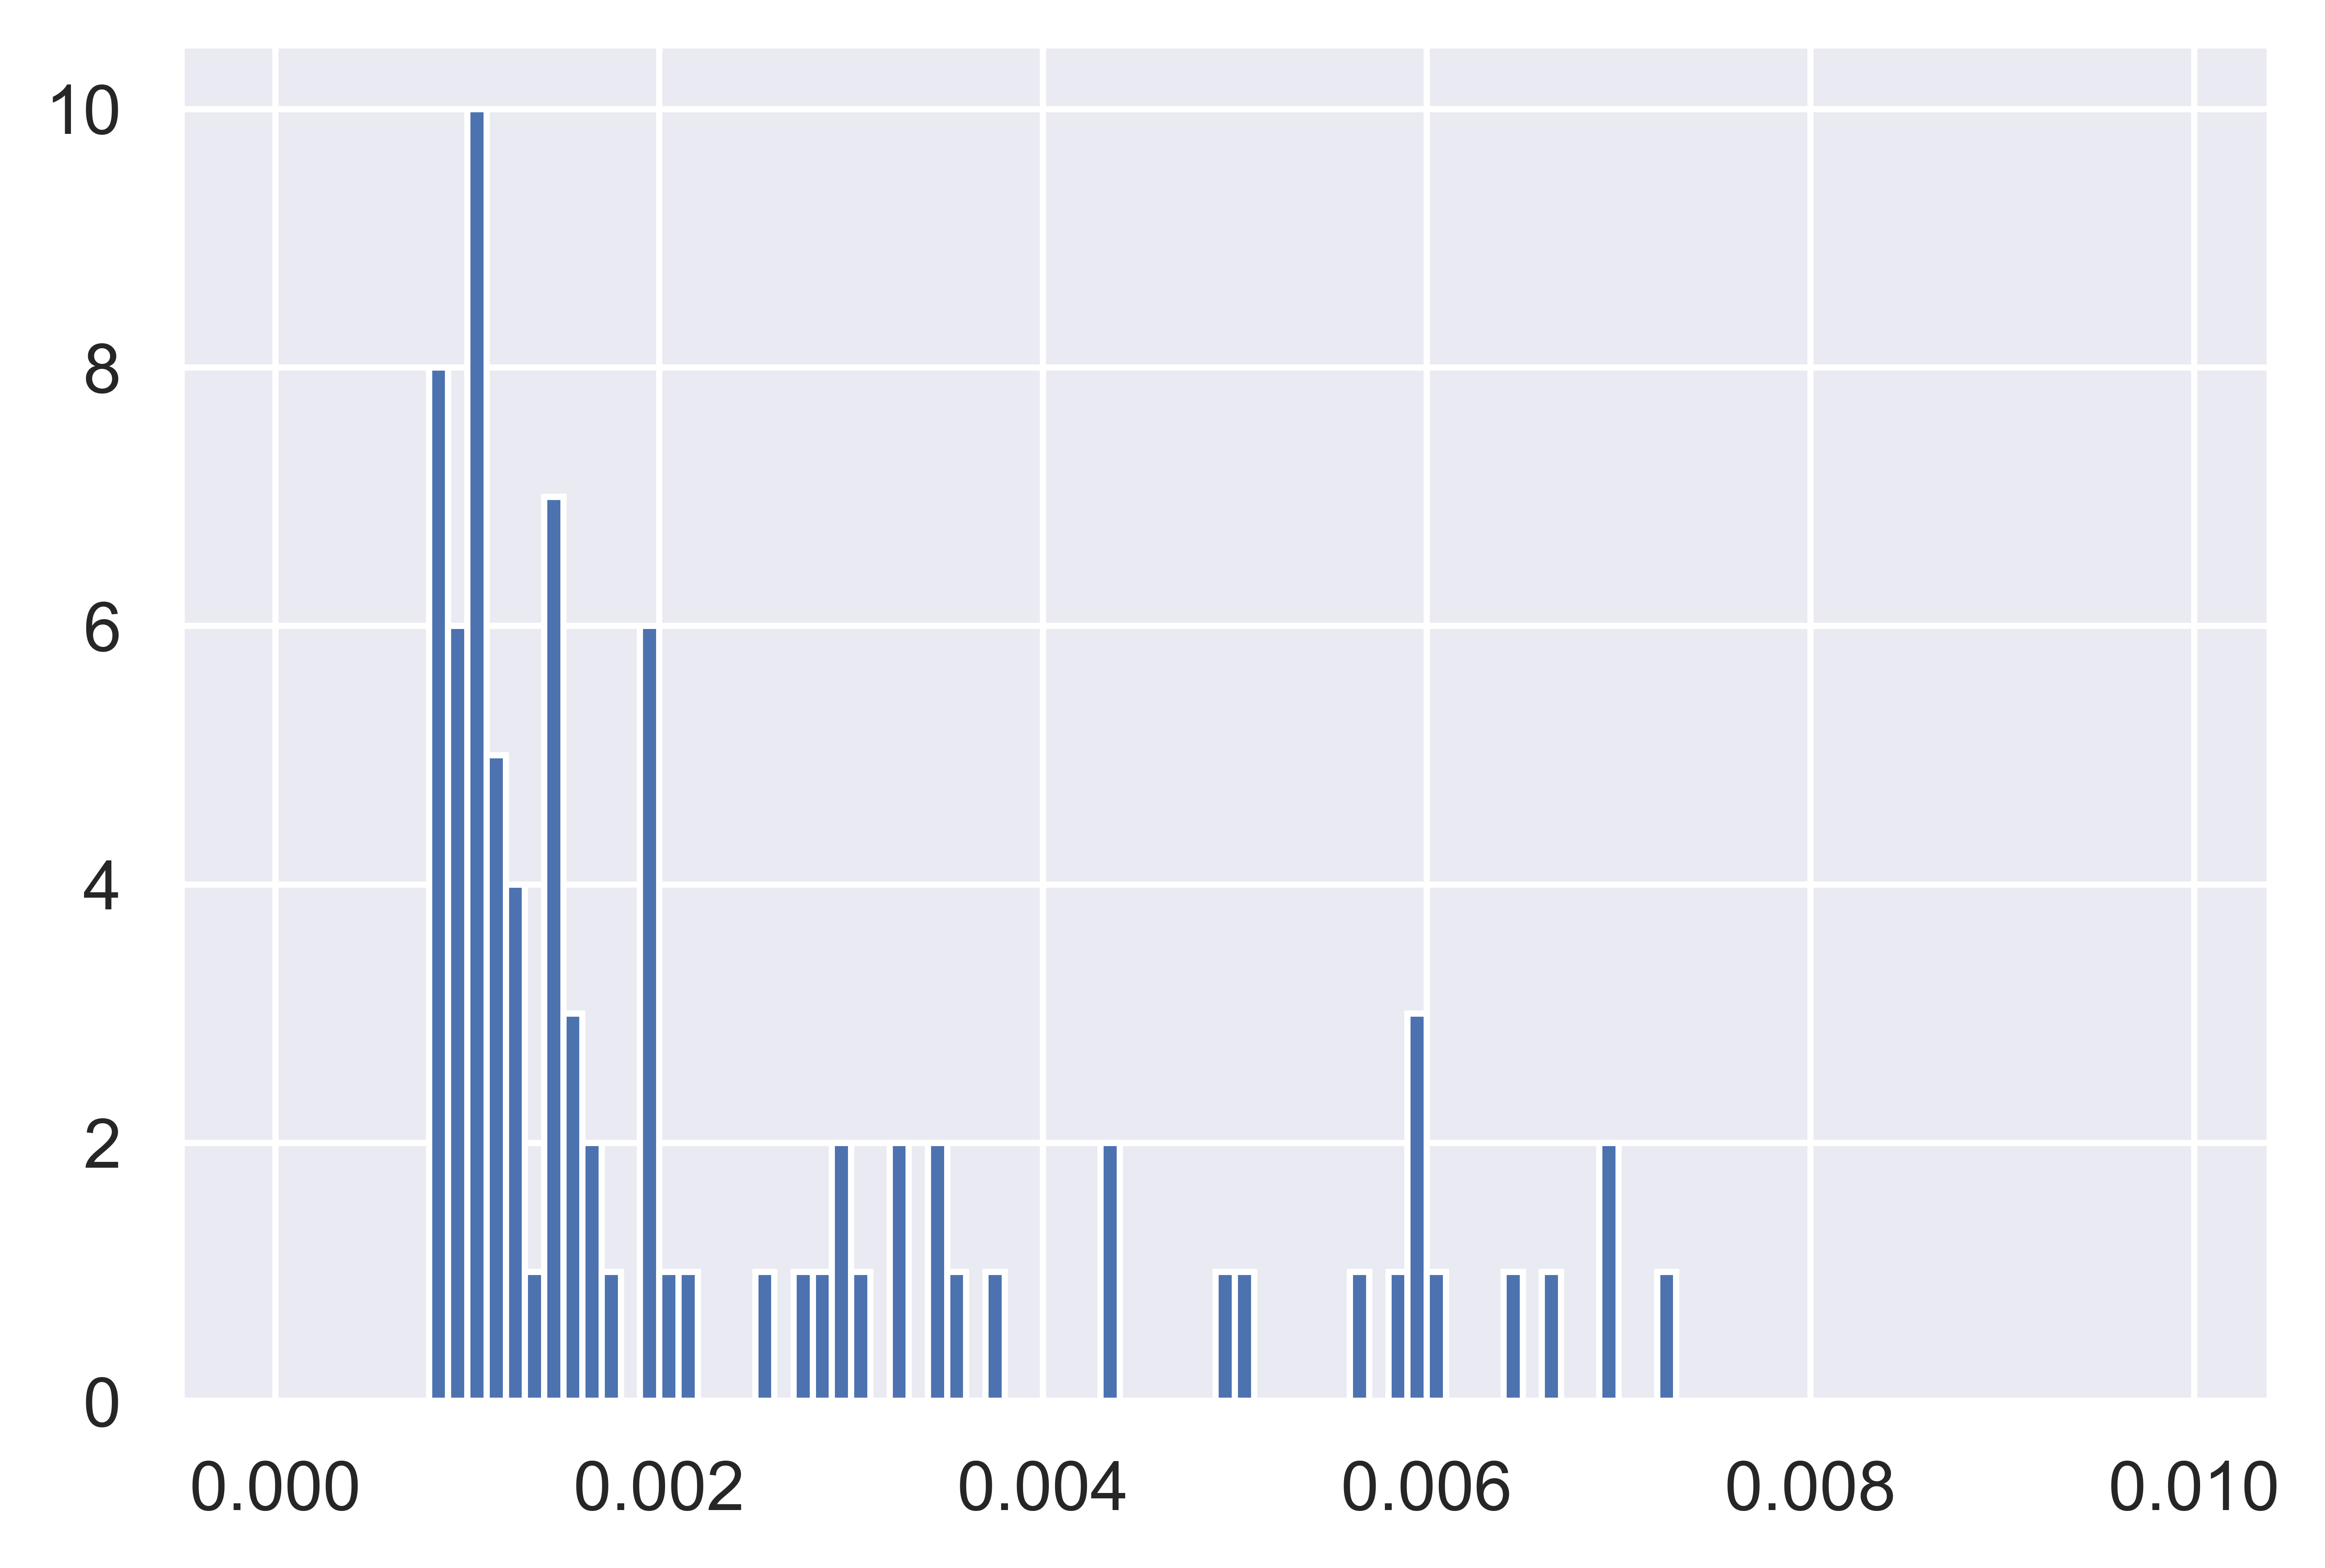

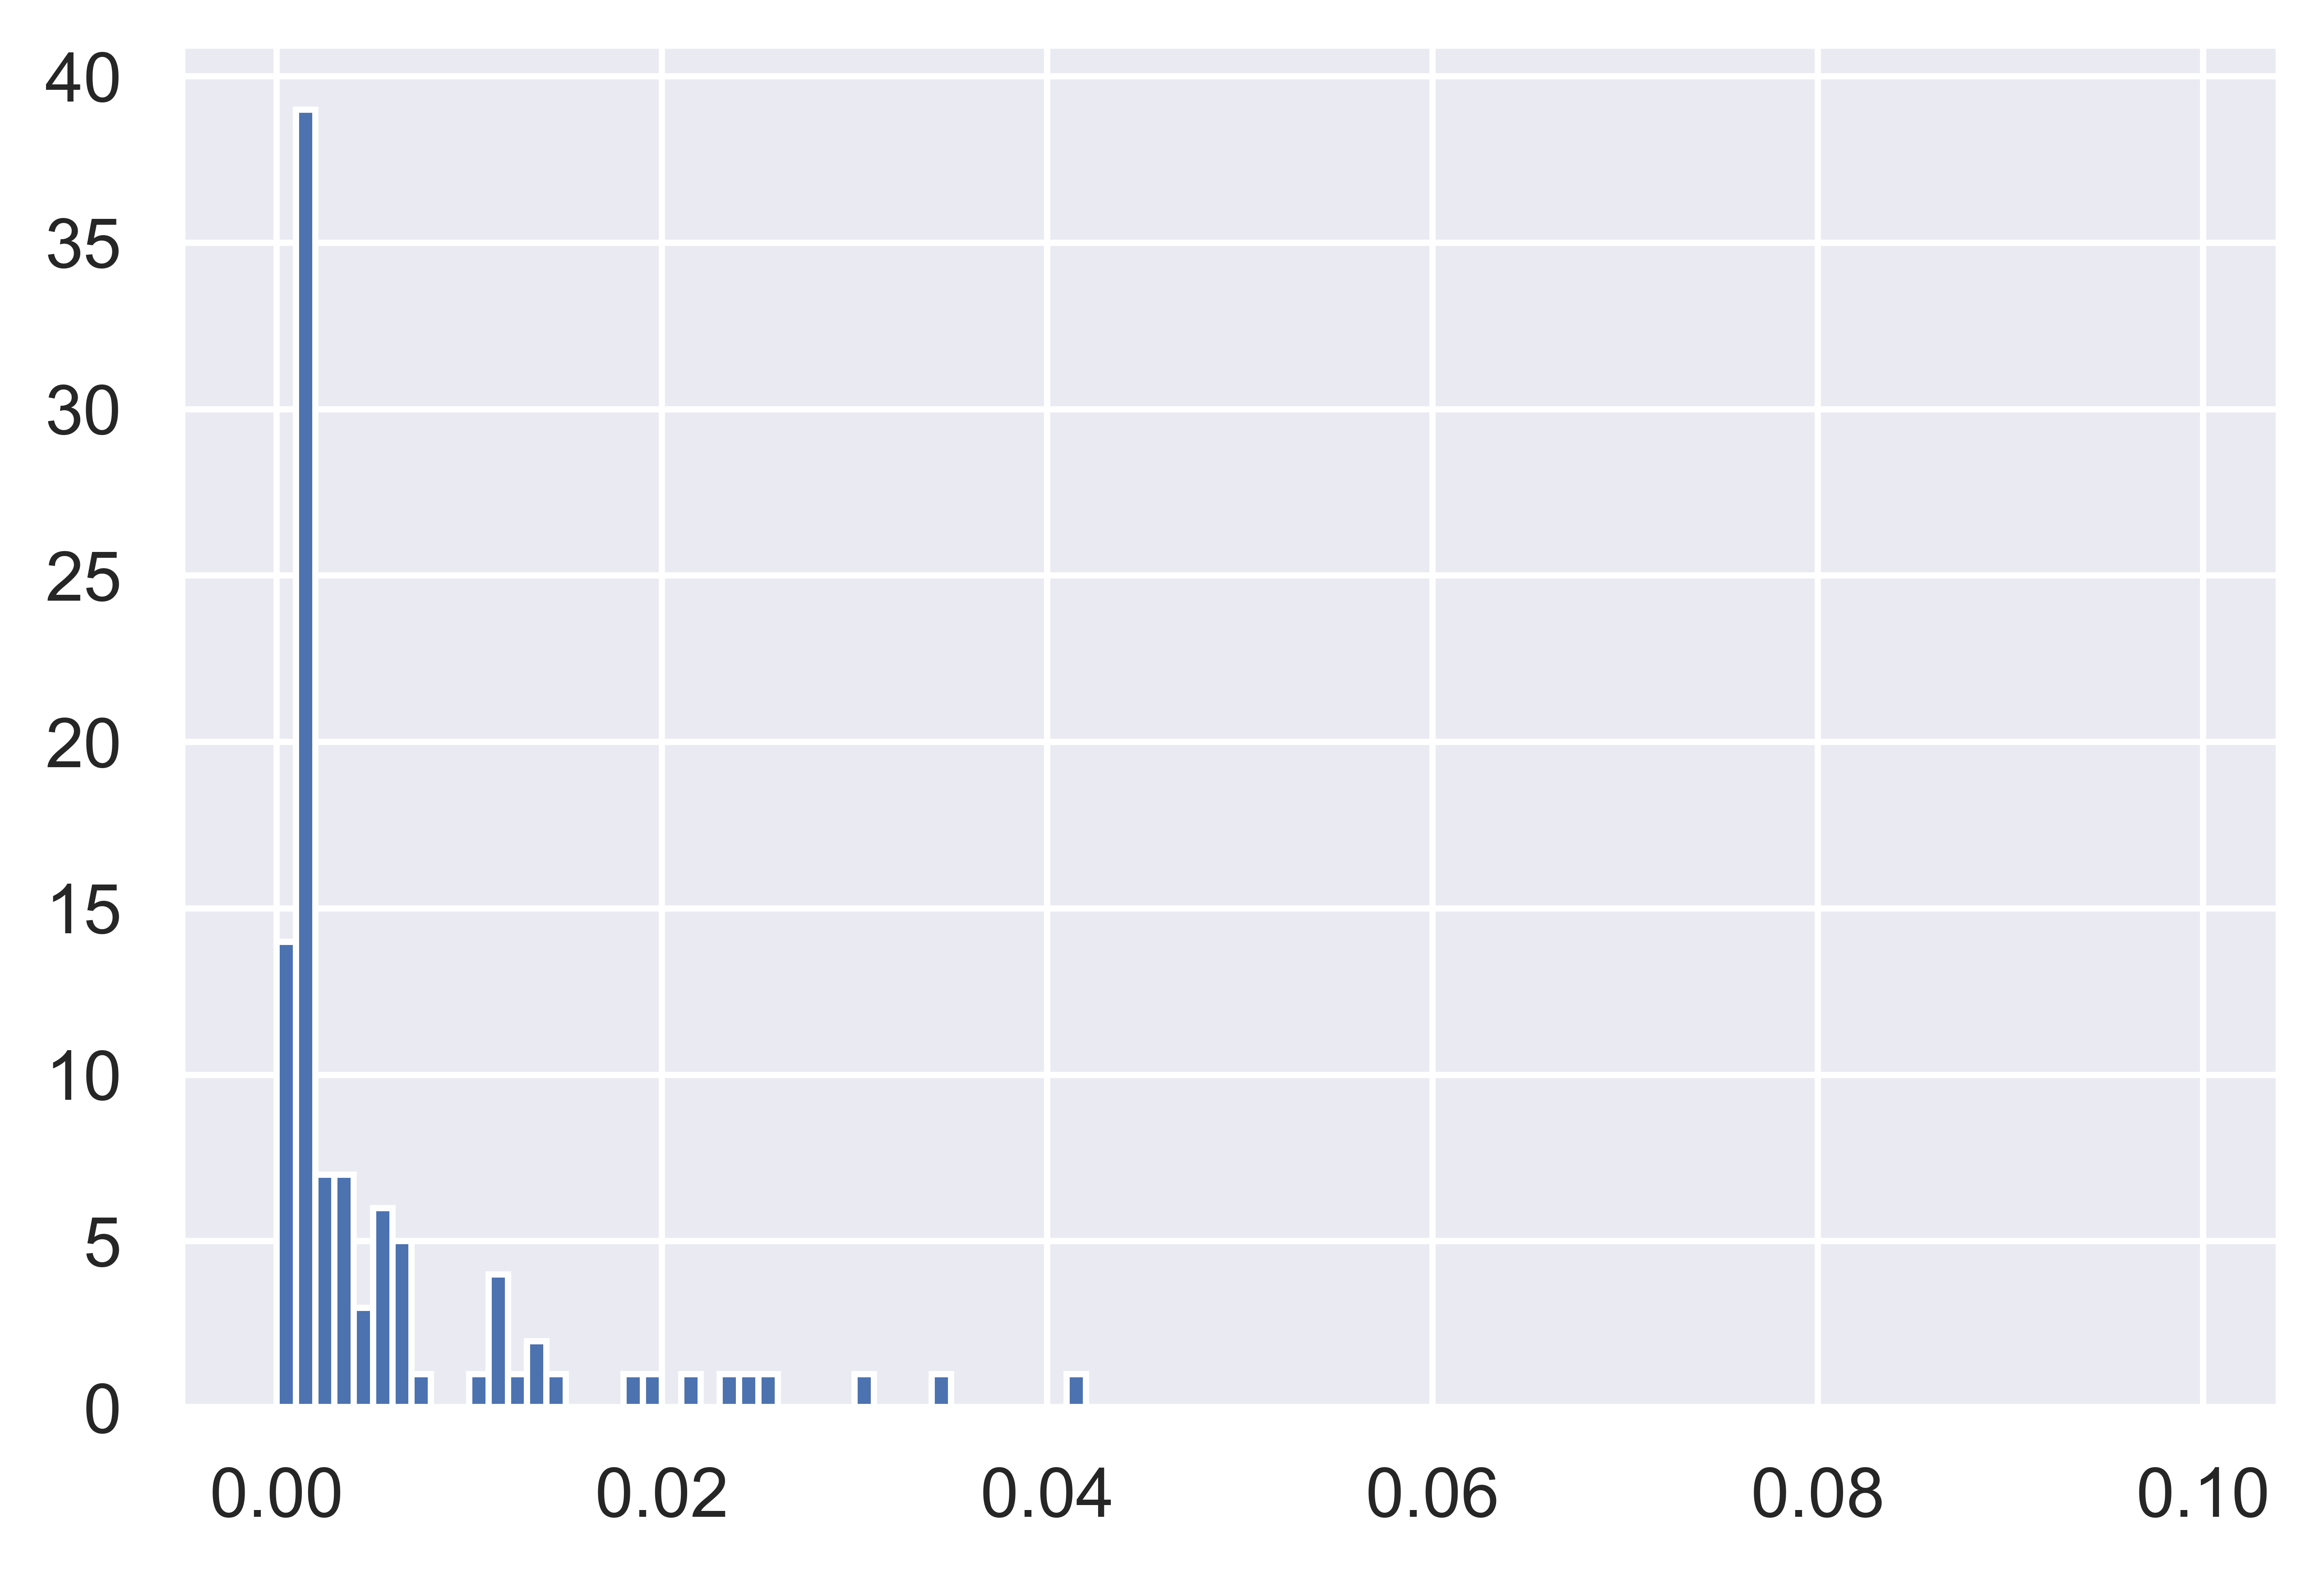

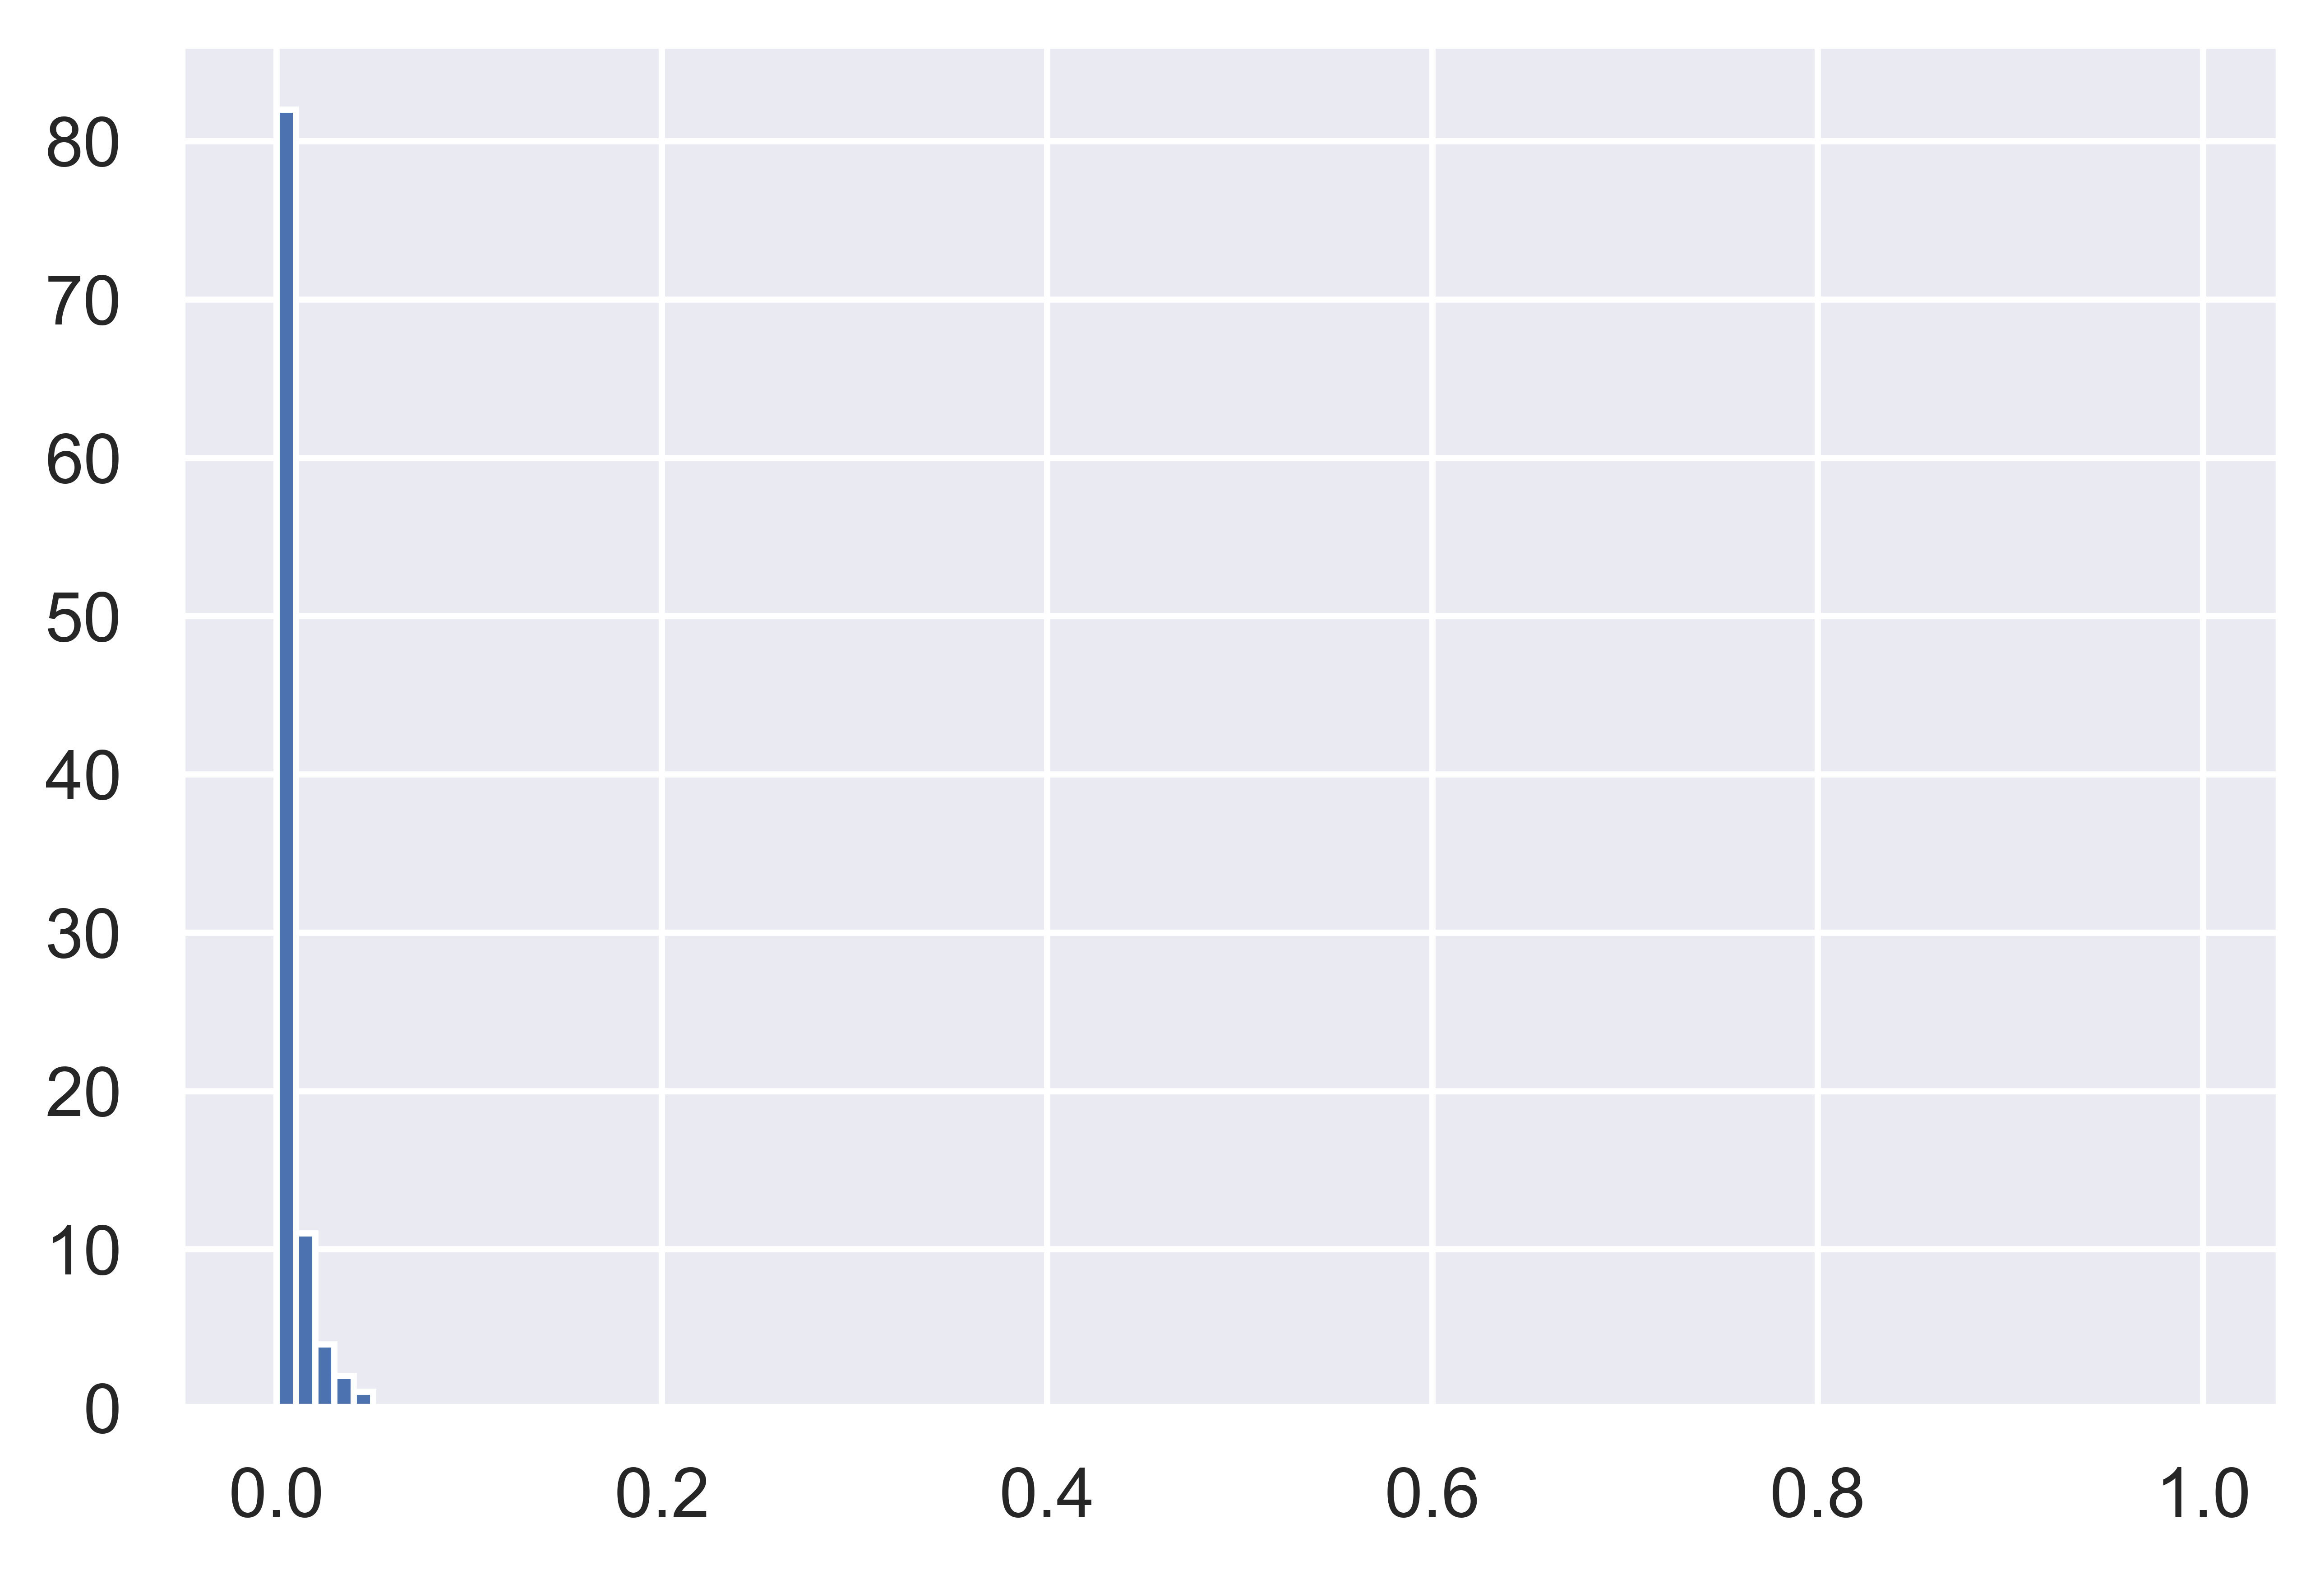

In [5]:
import itertools
import sys

def printOverLine(s):
    sys.stdout.write(s)  
    sys.stdout.write('\r')
    sys.stdout.flush()

# grid search    
    
iterations = 100

reals = [GenerateRealHPI() for i in range(iterations)]
simuls = [SimulateOCRResult(reals[i]) for i in range(iterations)]

params = [
    [0.7, 0.8, 0.9],
    [1.5, 1.6, 1.7],
    [3, 4, 5]
]

mmse = {}
mse = {}
msemax = {}
msemin = {}
msestd = {}
outliers = {}
outlierThreshold = 1

for p in itertools.product(*params):
    printOverLine('params: '+ str(p))
    for i in range(iterations):
        pred = timeRegressionWithGaps(simuls[i], eps1D=p[0], eps2D=p[1], minPointsForLine=p[2])
        if pred is not None:
            temp = np.mean((pred - reals[i]) ** 2)
            if temp > outlierThreshold:
                while True:
                    try:
                        outliers[p].append(i)
                        break
                    except:
                        outliers[p] = []
            else:
                while True:
                    try:
                        mse[p].append(temp)
                        break
                    except:
                        mse[p] = []
    temp = np.array(mse[p]) 
    mmse[p] = np.mean(temp)
    msestd[p] = np.std(temp)
    msemax[p] = np.max(temp)
    msemin[p] = np.min(temp)
    
    
plt.figure(dpi=1000)
for i, k in enumerate(mmse.keys()):     
    plt.scatter(mmse[k], i, alpha=0.3, c='red')
    plt.text(mmse[k], i, str(k) + ', ' + str(round(mmse[k], 6)), fontsize=6)
plt.axis('off')
plt.show();

print('outliers:')
if not outliers:
    print(None)
else:
    for k in outliers.keys():
        print(str(k) + ':\t' + str(len(outliers[k])))
print()
    
k = min(mmse, key = lambda k: mmse[k])
print('best params:\t' + str(k) + '\nmmse:\t' + str(mmse[k]) + '\nmsestd:\t' +\
      str(msestd[k]) + '\nmsemax:\t' + str(msemax[k]) + '\nmsemin:\t' + str(msemin[k]))

for j in [10 ** i for i in range(3)]:
    plt.figure(dpi=1000)
    plt.hist(mse[k], bins=[0.0001 * i * j for i in range(100)])
    plt.show();

In [6]:
'''txt = open('eg.txt', "r").read().split()
data = np.array([float(n) for n in txt])
data''';